In [1]:
import clip
import torch
import numpy as np
import os
import glob
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from scipy import stats

In [10]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [11]:
model, preprocess = clip.load("ViT-L/14@336px")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 427,944,193
Input resolution: 336
Context length: 77
Vocab size: 49408


In [12]:
preprocess

Compose(
    Resize(size=336, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(336, 336))
    <function _convert_image_to_rgb at 0x7fc1ea401820>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [43]:
image_dirs = sorted(glob.glob("images/*"))
image_files_dict = {}
for image_dir in image_dirs:
    image_version = os.path.basename(image_dir).split("_")[-1]
    image_files = sorted(glob.glob(os.path.join(image_dir, "*")))
    image_files_dict[image_version] = image_files

In [44]:
for key, value in image_files_dict.items():
    print("%s: %i" %(key, len(value)))

LLAMAgraph: 186
LLAMAgraphnoneigh: 179
LLAMAuserprompt: 153
graph: 197
graphnoneigh: 198
userprompt: 200


In [45]:
def load_imageset(image_files):
    """
    Each image should be named as the index of the prompt that generates it.
    Return:
        images: list of PIL Images
        preprocessed_images: list of preprocessed images as torch Tensors
        image_prompt_indices: indices of prompts that will be used in evaluation
    """
    images = [
        Image.open(file).convert("RGB") for file in image_files
    ]
    preprocessed_images = [
        preprocess(image) for image in images
    ]
    image_prompt_indices = [
        int(os.path.basename(file)[:3]) for file in image_files
    ]
    return images, preprocessed_images, image_prompt_indices

In [46]:
images_dict = {}
preprocessed_images_dict = {}
image_prompt_indices_dict = {}

for key, value in image_files_dict.items():
    images, preprocessed_images, image_prompt_indices = load_imageset(value)
    images_dict[key] = images
    preprocessed_images_dict[key] = preprocessed_images
    image_prompt_indices_dict[key] = image_prompt_indices

In [73]:
valid_prompt_indices = []

for prompt_index in list(range(200, 400)):
    valid = True
    for key, value in image_prompt_indices_dict.items():
        if prompt_index not in value:
            valid = False

    if valid:
        valid_prompt_indices.append(prompt_index - 200)

len(valid_prompt_indices)

131

In [78]:
prompts_csv = pd.read_csv("prompts.csv").rename(columns={"0": "index"})
prompts_csv = prompts_csv.iloc[valid_prompt_indices]

baseline_prompts = list(prompts_csv["UserPrompt"])
detailed_prompts = list(prompts_csv["DetailsNode"])
detailed_prompts[0]

'A community college is a type of educational institution. The term can have different meanings in different countries: many community colleges have an “open enrollment” for students who have graduated from high school (also known as senior secondary school). The term usually refers to a higher educational institution that provides workforce education and college transfer academic programs.  Some institutions maintain athletic teams and dormitories similar to their university counterparts.'

In [75]:
for key, value in images_dict.items():
    remapped_indices = [image_prompt_indices_dict[key].index(i + 200) for i in valid_prompt_indices]
    valid_value = [value[i] for i in remapped_indices]
    images_dict[key] = valid_value

for key, value in preprocessed_images_dict.items():
    remapped_indices = [image_prompt_indices_dict[key].index(i + 200) for i in valid_prompt_indices]
    valid_value = [value[i] for i in remapped_indices]
    preprocessed_images_dict[key] = valid_value

A community college is a type of educational institution. The term can have different meanings in different countries: many community colleges have an “open enrollment” for students who have graduated from high school (also known as senior secondary school). The term usually refers to a higher educational institution that provides workforce education and college transfer academic programs.  Some institutions maintain athletic teams and dormitories similar to their university counterparts.


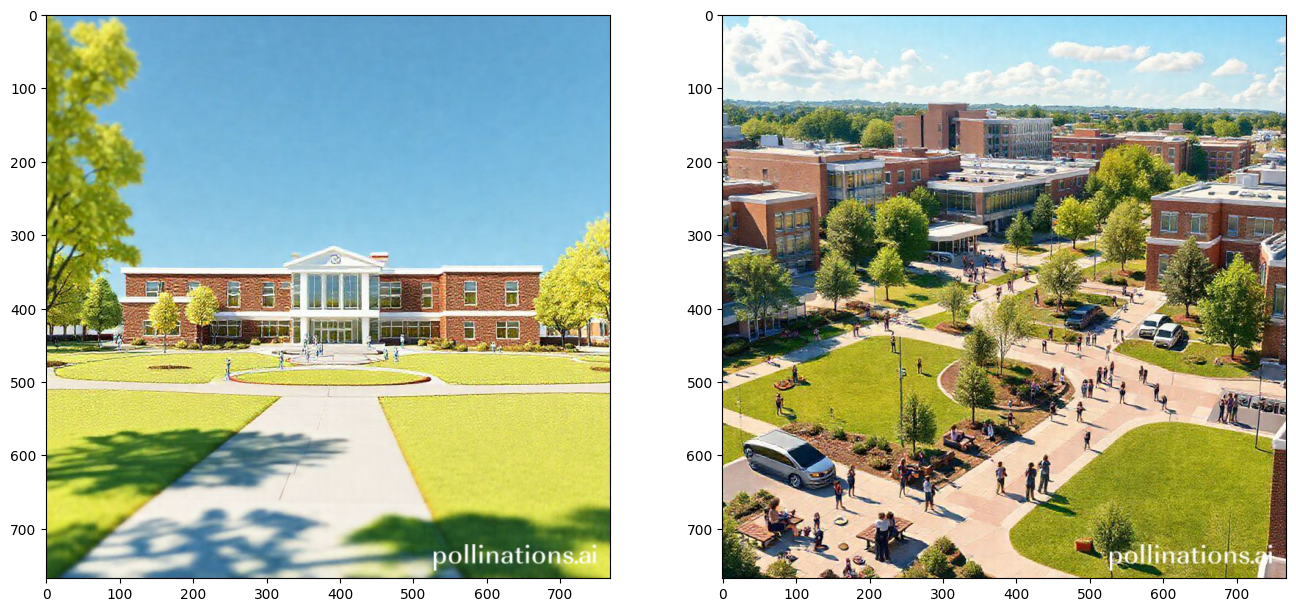

Jack Owen (born December 6, 1967) is an American musician, best known as a renowned guitarist in the death metal genre. He is currently the guitarist for death metal band Six Feet Under. He was one of the founding members of Cannibal Corpse. He stayed with the band from their formation in 1988 until 2004 when he left because he wanted to move on, as stated in the Centuries of Torment DVD. Later that year though, he was hired by Deicide—another influential and long-running Florida death metal band—with whom he recorded four albums. He left the band in 2016.In 2007, Owen played shows with Adrift before joining Order of Ennead at times when their guitarist, John Li, was unavailable. In 2009 Owen played guitar for a white power band Attack on their album Fade Away, though at the time he was unaware of their racist beliefs.


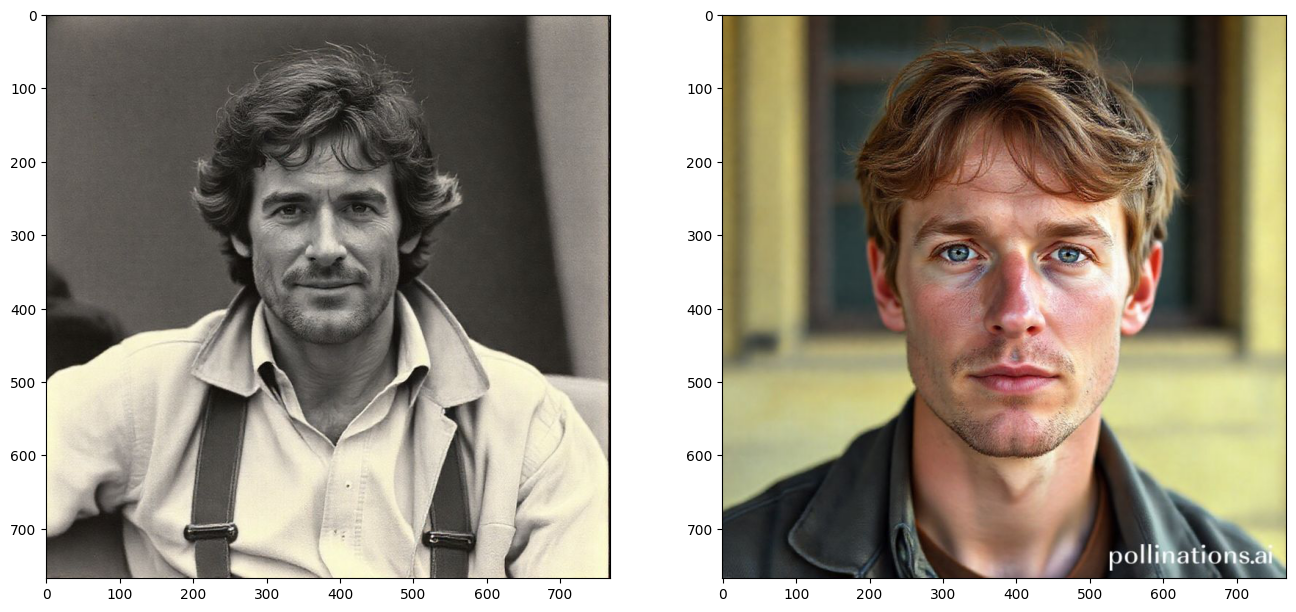

Paracoumaryl alcohol, also called p-coumaryl alcohol, 4-coumaryl alcohol, 4-hydroxycinnamyl alcohol, or 4-(3-hydroxy-1-propenyl)phenol, is a phytochemical, one of the monolignols. It is synthesized via the phenylpropanoid biochemical pathway. When polymerized, p-coumaryl alcohol forms lignin or lignans.Esters of p-coumaryl alcohol and fatty acids are the basis of epicuticular waxes covering the surfaces of apples.p-Coumaryl alcohol is an intermediate in biosynthesis of chavicol, stilbenoids, and coumarin.Research suggests derivatives of p-coumaryl alcohol may serve as dietary antioxidants.


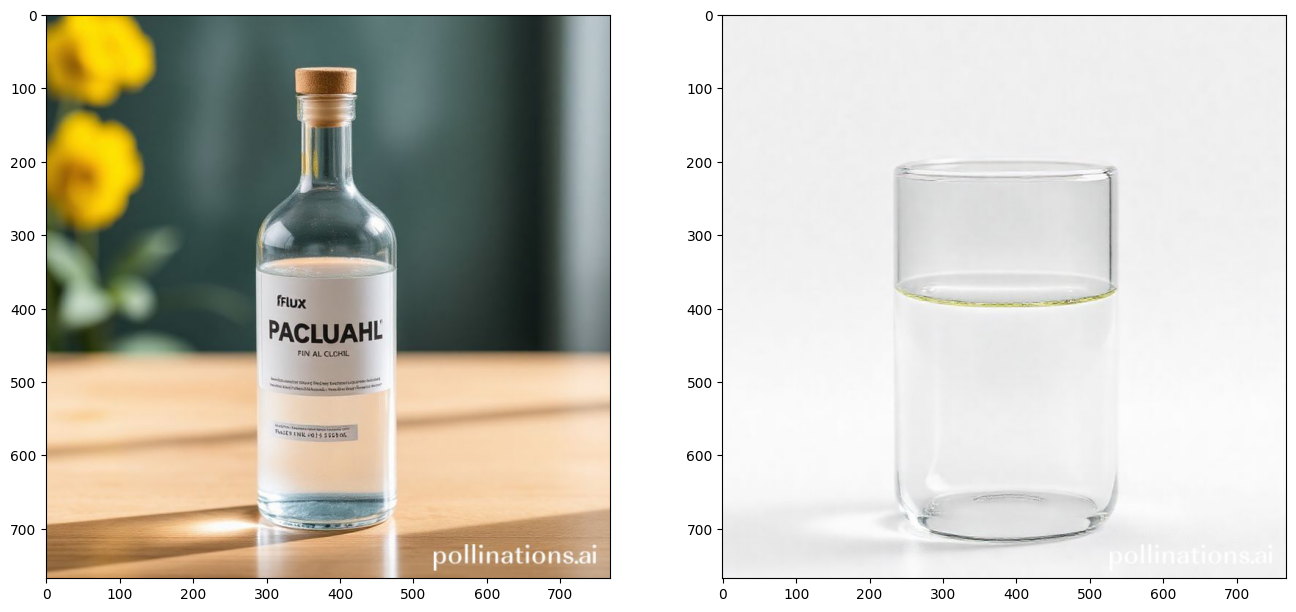

Joseph Andrew Scudero (born July 2, 1930) is a former American football safety in the National Football League for the Washington Redskins and Pittsburgh Steelers. He also played one season in Canada, with the Toronto Argonauts, where he was an all-star. He was born in San Francisco, California, and played college football at the University of San Francisco.


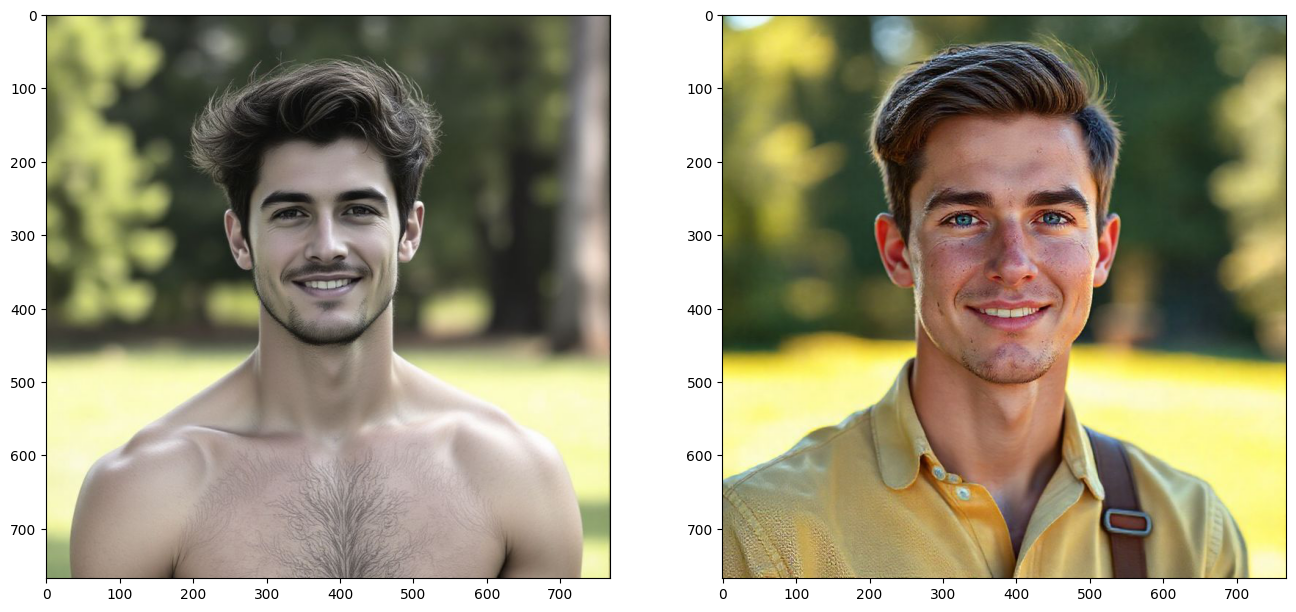

In [79]:
for i in [0, 1, 30, 31]:
    print(detailed_prompts[i])
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    axes[0].imshow(images_dict["userprompt"][i])
    axes[1].imshow(images_dict["LLAMAuserprompt"][i])
    plt.show()

In [83]:
baseline_text_tokens = clip.tokenize(baseline_prompts, truncate=True).cuda()
detailed_text_tokens = clip.tokenize(detailed_prompts, truncate=True).cuda()
with torch.no_grad():
    baseline_text_features = model.encode_text(baseline_text_tokens).float()
    detailed_text_features = model.encode_text(detailed_text_tokens).float()

    baseline_text_features /= baseline_text_features.norm(dim=-1, keepdim=True)
    detailed_text_features /= detailed_text_features.norm(dim=-1, keepdim=True)

In [84]:
baseline_similarities_dict = {}
detailed_similarities_dict = {}
for key, value in preprocessed_images_dict.items():
    with torch.no_grad():
        image_input = torch.tensor(np.stack(value)).cuda()
        image_features = model.encode_image(image_input).float()
        image_features /= image_features.norm(dim=-1, keepdim=True)
        
        baseline_similarity = np.diagonal(baseline_text_features.cpu().numpy() @ image_features.cpu().numpy().T)
        detailed_similarity = np.diagonal(detailed_text_features.cpu().numpy() @ image_features.cpu().numpy().T)

        baseline_similarities_dict[key] = baseline_similarity
        detailed_similarities_dict[key] = detailed_similarity

In [96]:
baseline_clipscore = pd.DataFrame(baseline_similarities_dict)
detailed_clipscore = pd.DataFrame(detailed_similarities_dict)
baseline_clipscore

LLAMAgraph  LLAMAgraphnoneigh  LLAMAuserprompt     graph  graphnoneigh  \
0      0.201463           0.189879         0.210517  0.192134      0.222273   
1      0.196939           0.193253         0.134601  0.195793      0.197506   
2      0.184882           0.201592         0.257503  0.238524      0.199911   
3      0.252074           0.228526         0.258291  0.236509      0.256856   
4      0.179092           0.252043         0.194489  0.257455      0.248250   
..          ...                ...              ...       ...           ...   
126    0.145745           0.141731         0.143205  0.155413      0.162886   
127    0.232907           0.209352         0.243264  0.254323      0.175478   
128    0.219410           0.222982         0.209164  0.254897      0.220016   
129    0.160279           0.176394         0.177842  0.243605      0.239505   
130    0.213635           0.185608         0.190503  0.206761      0.217021   

     userprompt  
0      0.172507  
1      0.202417  
2      0.157887  
3      0.267055  
4      0.156918  
..          ...  
126    0.212948  
127    0.218744  
128    0.227335  
129    0.232914  
130    0.170122  

[131 rows x 6 columns]

In [106]:
def clipscore(df, name):
    means = df.mean()
    sems = df.sem()
    
    n = len(df)
    
    # 3. Compute the 95% Confidence Interval
    # For a two-sided 95% CI, the critical value from the t-distribution is:
    t_val = stats.t.ppf(1 - 0.025, n - 1)  # 0.975 quantile for two-tailed test
    cis = sems * t_val
    
    fig, ax = plt.subplots(figsize=(6,4))
    
    # Plot the bar plot with error bars
    means.plot.bar(yerr=cis, ax=ax)
    
    # Add labels and title
    ax.set_title(name + " CLIPScore")
    ax.set_ylabel('CLIPScore')
    ax.set_ylim([0.15, 0.27])
    plt.xticks(rotation=45)

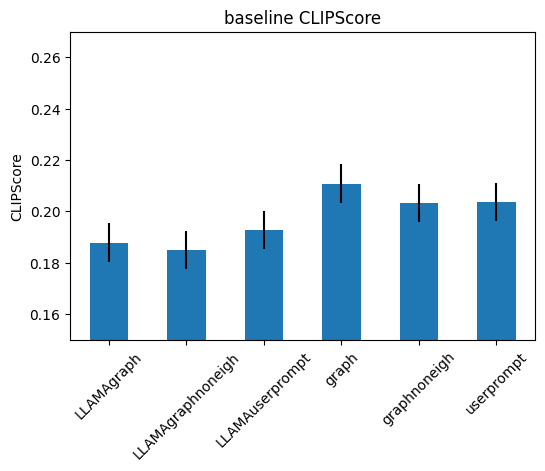

In [107]:
clipscore(baseline_clipscore, "baseline")

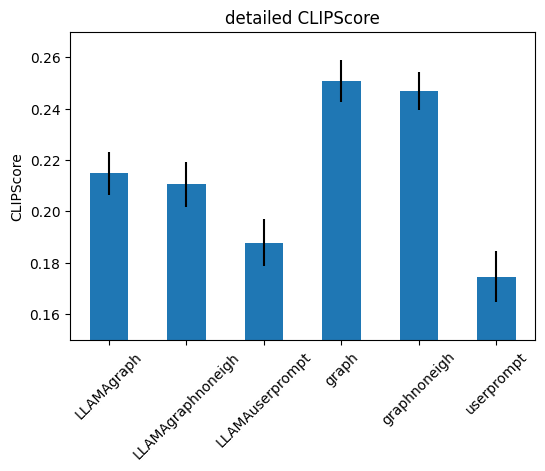

In [108]:
clipscore(detailed_clipscore, "detailed")